# Описание проекта

Подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Описание данных

**Технологический процесс**
- *Rougher feed* — исходное сырье
- *Rougher additions* (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - *Xanthate ** *— ксантогенат (промотер, или активатор флотации);
    - *Sulphate* — сульфат (на данном производстве сульфид натрия);
    - *Depressant* — депрессант (силикат натрия).
- *Rougher process* (англ. «грубый процесс») — флотация
- *Rougher tails* — отвальные хвосты
- *Float banks* — флотационная установка
- *Cleaner process* — очистка
- *Rougher Au* — черновой концентрат золота
- *Final Au* — финальный концентрат золота

**Параметры этапов**
- *air amount* — объём воздуха
- *fluid levels* — уровень жидкости
- *feed size* — размер гранул сырья
- *feed rate* — скорость подачи

## Наименование признаков

Наименование признаков должно быть такое:<br>
`[этап].[тип_параметра].[название_параметра]`

Возможные значения для блока `[этап]`:
- *rougher* — флотация
- *primary_cleaner* — первичная очистка
- *secondary_cleaner* — вторичная очистка
- *final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- *input* — параметры сырья
- *output* — параметры продукта
- *state* — параметры, характеризующие текущее состояние этапа
- *calculation* — расчётные характеристики

<a id="toc"></a>
## Оглавление

1. [Подготовка данных](#step1_0)<br>
    1.1 [Изучение данных в файлах](#step1_1)<br>
    1.2 [Проверка эффективности обогащения](#step1_2)<br>
    1.3 [Анализ признаков, недоступных в тестовой сборке](#step1_3)<br>
    1.4 [Предобработка данных](#step1_4)<br>
    [Вывод](#step1_5)<br>
2. [Анализ данных](#step2_0)<br>
    2.1 [Анализ изменения концентрации металлов](#step2_1)<br>
    2.2 [Сравнение распределений размеров гранул сырья](#step2_2)<br>
    2.3 [Исследование суммарной концентрации всех веществ на разных стадиях](#step2_3)<br>
    [Вывод](#step2_4)<br>
3. [Построение и обучение модели](#step3_0)<br>
    3.1 [Разработка функции для вычисления итоговой sMAPE](#step3_1)<br>
    3.2 [Обучение моделей](#step3_2)<br>
    [Вывод](#step3_3)<br>
4. [Общий вывод](#step4_0)

<a id="step1_0"></a>
## 1. Подготовка данных

#### [Оглавление](#toc)

In [1]:
# Подключение библиотек, необходимых модулей и алгоритмов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


from scipy import stats as st

from IPython.display import display

Определим константные значения, которые мы будем использовать в дальнейшем.

In [2]:
# Параметр рандомизиции
RAND_SEED = 12345

<a id="step1_1"></a>
### 1.1 Изучение данных в файлах

Прочитаем данные из файлов, сохраним в соответствующие переменные, выведем названия столбцов и первые 5 строк для каждой таблицы.

In [3]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')

print(gold_recovery_train.columns)
display(gold_recovery_train.head())

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Мы прочитали файл с обйчающей выборкой - `gold_recovery_train.csv`. Первоначально, вывели все названия столбцов. Видно, что все названия состоят только из латинских символов, в них нет лишних пробелов (спереди и сзади), все символы приведены к нижнему регистру. Названия соответствуют ожидаемым, а именно `[этап].[тип_параметра].[название_параметра]`. Из вывода информации о таблице видно, что размер таблицы 16860 * 87. Что касается типов данных, то для всех признаков он определен, как float64 (вещественные числа), единственное признак даты и времени определен как object. Также стоит отметить, что в строках есть пропуски, которые необходимо будет обработать.

In [5]:
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')

print(gold_recovery_test.columns)
display(gold_recovery_test.head())

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Для файла с тестовой выборкой результат аналогичный, за тем исключением, что размер таблицы составляет 5856 * 53. Колонок здесь меньше, нужно будет про это не забыть в дальнейшем.

In [7]:
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

print(gold_recovery_full.columns)
display(gold_recovery_full.head())

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Как можно было ожидать, размер исходных данных 22716 * 87. Это говорит о том, что при разбиении на обучающую и тестовую выборки строки не потерялись. Здесь также есть пустые значения, но их мы трогать не будем - полезно иметь первоначальную полную выборку без изменений.

<a id="step1_2"></a>
### 1.2 Проверка эффективности обогащения

На данном этапе проверим, что эффективность обогащения после этапа флотации (`rougher.output.recovery`) на обучающей выборке рассчитана правильно.

Эффективность будем проверять по следующей формуле:
***
Recovery = ((C * (F - T)) / (F * (C - T))) * 100%
***

где:<br>
- *C* — доля золота в концентрате после флотации/очистки;
- *F* — доля золота в сырье/концентрате до флотации/очистки;
- *T* — доля золота в отвальных хвостах после флотации/очистки.

В нашей обучающей выборке (`gold_recovery_train`), согласно правилам наименования:
- *C* - `rougher.output.concentrate_au`
- *F* - `rougher.input.feed_au`
- *T* - `rougher.output.tail_au`

При этом, значение *Recovery* из таблицы находится в столбце `rougher.output.recovery`

Создадим отдельную таблицу, куда занесем только необходимые параметры.

In [9]:
df_check_recovery = gold_recovery_train[['rougher.output.concentrate_au', 
                                         'rougher.input.feed_au', 
                                         'rougher.output.tail_au', 
                                         'rougher.output.recovery']]

Поскольку у нас есть пропуски в таблице, а их заполнение в любом случае приведет к искажению первоначальной картины - исключим из этой таблицы все строки, где есть пропуски в любой из колонок. Таким образом, в нашем распоряжении будут все значения, чтобы самостоятельно посчитать эффективность, и сравнить ее со значением в таблице.

In [10]:
print(df_check_recovery.shape)
print(df_check_recovery.isnull().sum())

(16860, 4)
rougher.output.concentrate_au      82
rougher.input.feed_au              83
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64


In [11]:
df_check_recovery = df_check_recovery.dropna()
df_check_recovery = df_check_recovery.reset_index(drop=True)

In [12]:
print(df_check_recovery.shape)
print(df_check_recovery.isnull().sum())

(14287, 4)
rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
rougher.output.recovery          0
dtype: int64


In [13]:
check_rougher_output_recovery = (
    ((df_check_recovery['rougher.output.concentrate_au'] *
            (df_check_recovery['rougher.input.feed_au'] - df_check_recovery['rougher.output.tail_au'])) /
        (df_check_recovery['rougher.input.feed_au'] * 
            (df_check_recovery['rougher.output.concentrate_au'] - df_check_recovery['rougher.output.tail_au']))) * 
     100
)

Теперь чтобы оценить правильность между полученными значениями и значениями признака из таблицы, найдем среднее абсолютное отклонение MAE (Mean Absolute Error).

In [14]:
print(mean_absolute_error(df_check_recovery['rougher.output.recovery'], check_rougher_output_recovery)) 

9.444891926100695e-15


Мы получили очень маленькое значение MAE. Можно сказать, что самостоятельно посчитанные значения эффективности и значения из таблицы совпадают. Причина получения не нулевого значения среднего абсолютного отклонения в том, что когда мы считали эффективность, мы получали вещественные числа, и не округляли их до какого-то определенного знака после запятой. Из-за особенности хранения вещественных чисел в Python, нельзя их сравнивать напрямую, а только с какой-то точностью. Поскольку точностью мы не располагаем, то можно принять значение MAE пренебрежительно маленьким.

<a id="step1_3"></a>
### 1.3 Анализ признаков, недоступных в тестовой сборке

Ранее мы увидили, что в тестовой выборке колонок меньше, чем обучающей. Рассмотрим, какие столбцы пропущены.

In [15]:
set(list(gold_recovery_train.columns)) - set(list(gold_recovery_test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке по сравнению с обучающей , как мы видим, нет параметров расчетных характеристик (`calculation`). Это объясняется, что они расчитываются значительно позже сбора данных для тестовой выборки. Также в выборке нет параметров продукта, то есть целевых признаков для каждого этапа (признак `output`). Эта выборка тестовая, и как раз на этой выборке мы и должны будем проверить будущую модель для предсказывания результатов.

<a id="step1_4"></a>
### 1.4 Предобработка данных

Как уже было сказано ранее, чтобы дальше анализировать данные необходимо избавиться от пропусков в обучающей и тестовой выборках, а также указать верный тип данных для хранения даты.

Из условий задачи мы знаем, что соседние по времени параметры часто похожи. Поэтому заполним их с помощью функции fillna с параметром `method='ffill'`.

Удалим пропуски в целевых столбцах. И уже после этого заполним пропуски.

In [16]:
print('nulls in rougher.output.recovery:', gold_recovery_train['rougher.output.recovery'].isnull().sum())
print('nulls in final.output.recovery:', gold_recovery_train['final.output.recovery'].isnull().sum())

nulls in rougher.output.recovery: 2573
nulls in final.output.recovery: 1521


In [17]:
gold_recovery_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
gold_recovery_train = gold_recovery_train.reset_index(drop=True)

In [18]:
print('nulls in rougher.output.recovery:', gold_recovery_train['rougher.output.recovery'].isnull().sum())
print('nulls in final.output.recovery:', gold_recovery_train['final.output.recovery'].isnull().sum())

nulls in rougher.output.recovery: 0
nulls in final.output.recovery: 0


In [19]:
# сначала подсчитаем в каких колонках сколько пустых занчений, а затем просуммируем эти значение. 
        # Таким образом мы узнаем, сколько пустых ячеек всего.
print('Before fillna: ', gold_recovery_train.isnull().sum().sum())

# Заполним пропуски
gold_recovery_train = gold_recovery_train.fillna(method='ffill')

# Проверим
print('After fillna: ', gold_recovery_train.isnull().sum().sum())

Before fillna:  4100
After fillna:  0


Сделаем тоже самое для тестовой выборки.

In [20]:
print('Before fillna: ', gold_recovery_test.isnull().sum().sum())
gold_recovery_test = gold_recovery_test.fillna(method='ffill')
print('After fillna: ', gold_recovery_test.isnull().sum().sum())

Before fillna:  2360
After fillna:  0


In [21]:
print('Before change dtype" ', gold_recovery_train['date'].dtype)
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format='%Y-%m-%dT%H:%M:%S')
print('After change dtype" ', gold_recovery_train['date'].dtype)

Before change dtype"  object
After change dtype"  datetime64[ns]


In [22]:
print('Before change dtype" ', gold_recovery_test['date'].dtype)
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format='%Y-%m-%dT%H:%M:%S')
print('After change dtype" ', gold_recovery_test['date'].dtype)

Before change dtype"  object
After change dtype"  datetime64[ns]


In [23]:
print('Before change dtype" ', gold_recovery_full['date'].dtype)
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format='%Y-%m-%dT%H:%M:%S')
print('After change dtype" ', gold_recovery_full['date'].dtype)

Before change dtype"  object
After change dtype"  datetime64[ns]


<a id="step1_5"></a>
### Вывод

На данном этапе мы подготавливали данные для дальнейшего анализа и машинного обучения. Изначально мы прочитали данные из файлов, и получили соответственно предподготовленные обучающую и тестовую выборки, а также все исходные сырые данные. Затем мы проверили корректность расчитанный эффективности обогащения в обучающей выборке. Для этого мы самостоятельно посчитали это значение для строк, в которых уже были данные, и высчитали среднее абсолютное отклонение. Значение MAE получилось пренебрежительно малым (не нулевым - из-за того что мы сравнивали вещественные числа), так что мы убедились что расчеты в обучающей выборке верны. Затем для тестовой выборки определили отсутствующие признаки, по сравнению с обучающей выборкой. Отсутсвуют только целевые признаки и расчетные характеристики, что является нормальным для тестовой выборки. Ну и на заключительном шаге мы провели предобработку данных - заполнили пропуски и подкорректировали типы данных.

<a id="step2_0"></a>
## 2. Анализ данных

#### [Оглавление](#toc)

<a id="step2_1"></a>
### 2.1 Анализ изменения концентрации металлов

Посмотрим, как меняется концентрация металлов(Au, Ag, Pb) на различных этапах очистки.

В обучающей выборке концентрация хранится в столбцах:<br>
`rougher.input.feed_{ME}`,<br>
`rougher.output.concentrate_{ME}`,<br>
`primary_cleaner.output.concentrate_{ME}`,<br>
`final.output.concentrate_{ME}`<br>

Построим гистограммы для каждого из металлов на каждом этапе очистки. Таким образом мы увидим частоту появления определенной концентрации.

In [24]:
metals = ['au', 'ag', 'pb']

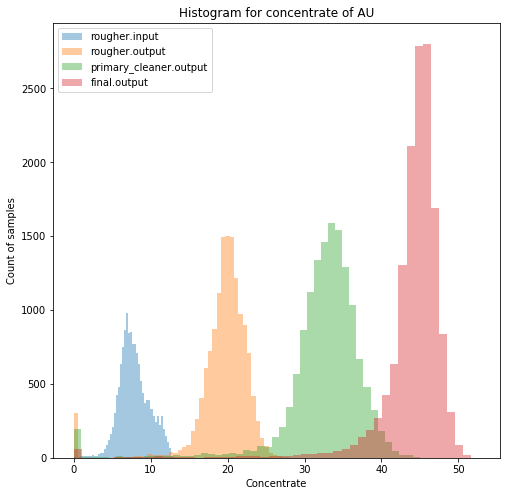

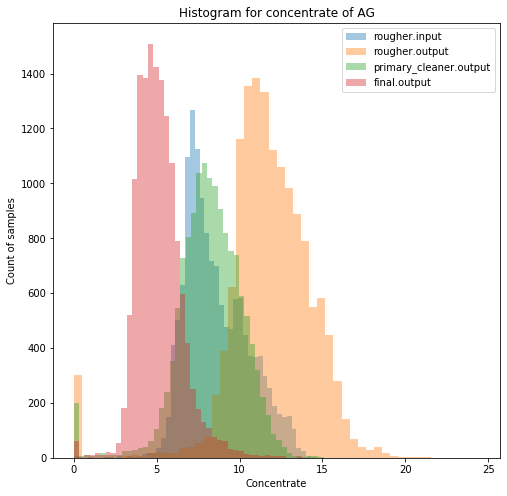

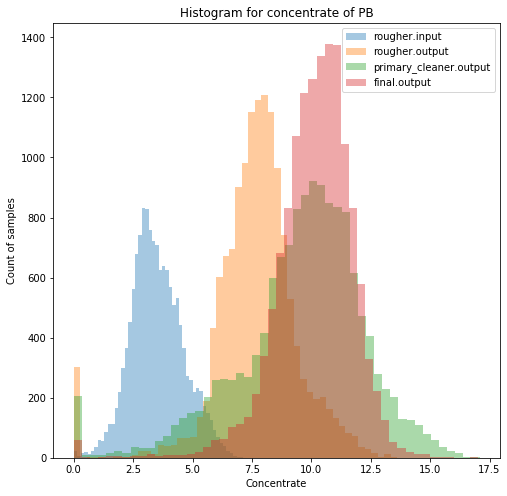

In [25]:
for cur_metal in metals:
    fig, ax = plt.subplots(figsize=(8,8))
    
    sns.distplot(gold_recovery_train['rougher.input.feed_' + cur_metal], 
                 kde=False, label='rougher.input')
    sns.distplot(gold_recovery_train['rougher.output.concentrate_' + cur_metal], 
                 kde=False, label='rougher.output')
    sns.distplot(gold_recovery_train['primary_cleaner.output.concentrate_' + cur_metal], 
                 kde=False, label='primary_cleaner.output')
    sns.distplot(gold_recovery_train['final.output.concentrate_' + cur_metal], 
                 kde=False, label='final.output')
    
    plt.title('Histogram for concentrate of ' + str.upper(cur_metal))
    plt.xlabel('Concentrate')
    plt.ylabel('Count of samples')
    ax.legend(loc='best')
    
    plt.show()

Первый график построен для золота, которое нас больше всего и интересует. Видно, что в ходе очистки концентрация постепенно увеличивается (первоначальная концентрация в исходном сырье -> концентрация после флотации -> концентрация после первичной очистки -> финальный концентрат). По этим данным можно сделать вывод, что технологический процесс по очищению золота из руды налажен качественно - практически для всех образцов удалось достигнуть поставленной цели.<br>
Второй график построен для серебра. Сразу можно сказать, что не стоит задача повысить концентрацию серебра в продукте. После флотации, которая как раз и направлена на обогащение руды и выделение отвальных остатков с низкой концентрацией ценных металлов, соотношение серебра повышается. Однако далее, мы все таки отделяем серебро, и стараемся уменьшить его количество в итоговом продукте. Возможно на отвальными хвостами для данных этапов, производится уже отдельный процесс очищения серебра.<br> 
Третий график показывает концентрацию свинца на каждом из этапов. Видно, что очистка от него не первостепенная задача, но она все же ведется. По факту в конечном продукте остается достаточно высокая концентрация. Данный металл, не стараются усилеено выделить из смеси.

<a id="step2_2"></a>
### 2.2 Сравнение распределений размеров гранул сырья

Посмотрим на распределение размеров гранул сырья на обучающей и тестовой выборках. Если распределения будут сильно отличаются друг от друга, оценка модели будет неправильной.

В выборках размеры гранул сырья хранится в столбце: `rougher.input.feed_size`

Построим график распределения плотности вероятностей для размера гранул сырья.

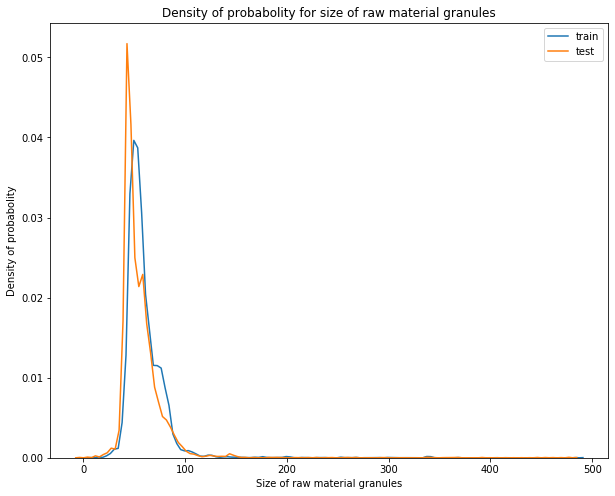

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
    
sns.distplot(gold_recovery_train['rougher.input.feed_size'], hist=False, label='train')
sns.distplot(gold_recovery_test['rougher.input.feed_size'], hist=False, label='test')

plt.title('Density of probabolity for size of raw material granules')
plt.xlabel('Size of raw material granules')
plt.ylabel('Density of probabolity')
ax.legend(loc='best')

plt.show()

Из графика видно, что оба распределения похожи и подчиняются одному закону. Это показывает, что размер гранул сырья для обучающей и тестовой выборки будут одинаково влиять на обучение модели.

<a id="step2_3"></a>
### 2.3 Исследование суммарной концентрации всех веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

В пункте [2.1](#step2_1) было указано, как нужные значения хранятся в таблице. Однако в наших данных, кроме металлов (Au, Ag, Pb), есть еще и концентрация остальных веществ (sol).

Для каждой стадии посчитаем суммарную концентрацию всех веществ и выведем гистограмму распределения этих значений.

In [27]:
stages = ['rougher.input.feed_', 
          'rougher.output.concentrate_', 
          'primary_cleaner.output.concentrate_', 
          'final.output.concentrate_']
materials = metals + ['sol']

In [28]:
def get_sum_concentrate(df_check):
    sum_concentrate = pd.DataFrame()
    
    for cur_stage in stages:
        sum_concentrate[cur_stage] = pd.Series(0, index=df_check.index)
        for cur_material in materials:
            sum_concentrate[cur_stage] += df_check[cur_stage + cur_material]
    
    return sum_concentrate

In [29]:
def print_hist_concentrate_for_every_stage(df_check):
    for cur_stage in stages:
        fig, ax = plt.subplots(figsize=(16,5))
        sns.distplot(df_check[cur_stage], kde=False, label=cur_stage[:cur_stage.rfind('.')])
        plt.title('Histogram of sum concentrate for ' + cur_stage[:cur_stage.rfind('.')] + ' stage')
        plt.xlabel('Sum concentrate')
        plt.ylabel('Count of samples')
        plt.show()

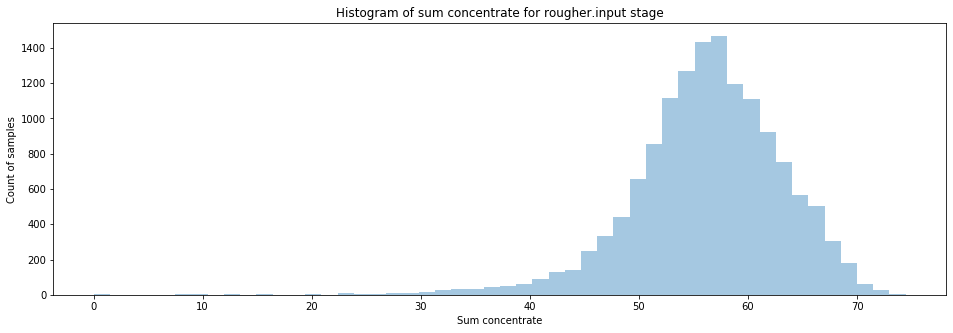

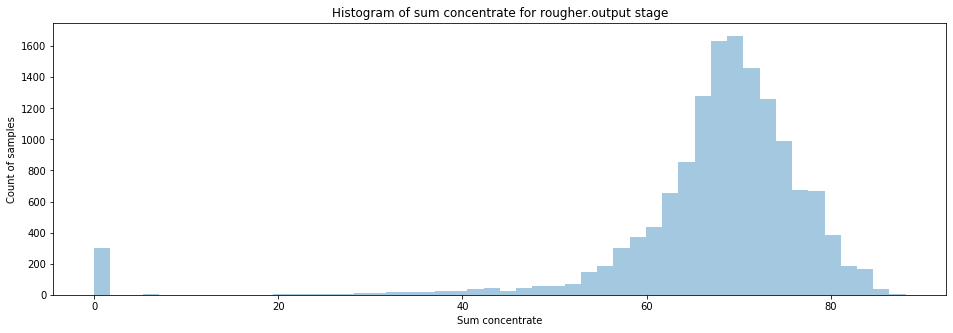

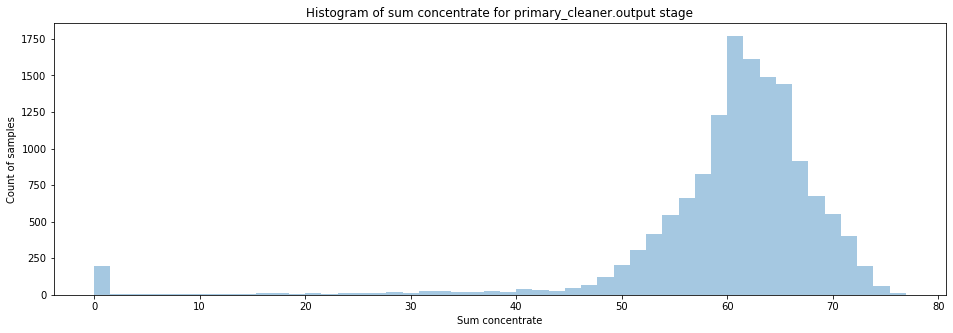

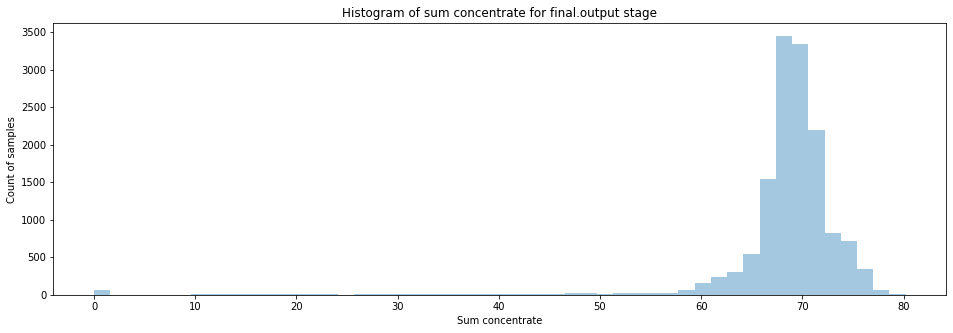

In [30]:
sum_concentrate_train = get_sum_concentrate(gold_recovery_train)
print_hist_concentrate_for_every_stage(sum_concentrate_train)

Логическое ограничение, что концентрат веществ не может быть больше 100 выполняется для всех графиков. Однако, мы видим, что присутствуют аномальные значения, где суммарный концентрат равен или очень близок к 0. Это означает, что во время очистки руды сырье подавалось совсем без полезных веществ (или ее было очень мало), то есть из руды ничего нельзя выделить. Данную характеристику можно контролировать заранее. На таких данных не стоит обучать модель. Уберем строки, где суммарный концентрат для исходного сырья менее 1%.

In [31]:
train_drop_indexes = []

cur_stage = stages[0]
train_drop_indexes.extend(list(sum_concentrate_train.loc[sum_concentrate_train[cur_stage] < 1].index))

train_drop_indexes = set(train_drop_indexes)

gold_recovery_train_prepared = gold_recovery_train.drop(train_drop_indexes)
gold_recovery_train_prepared = gold_recovery_train_prepared.reset_index(drop=True)

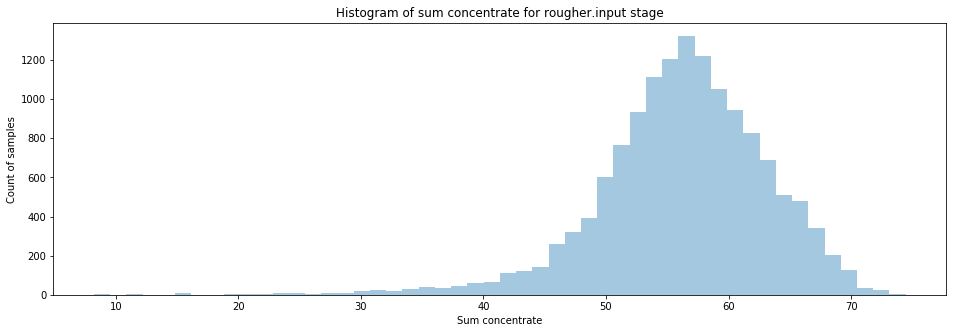

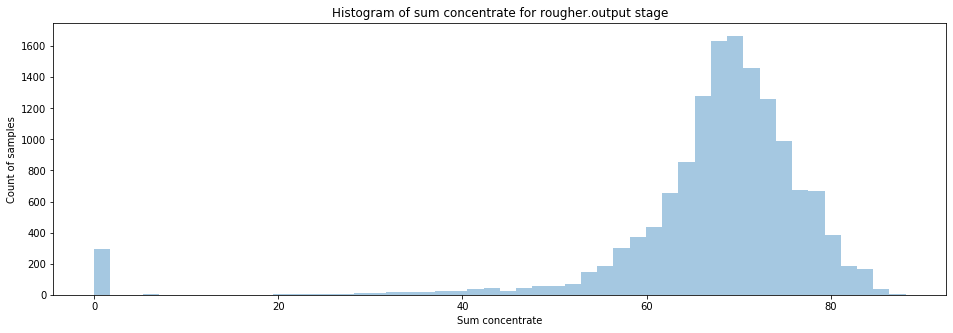

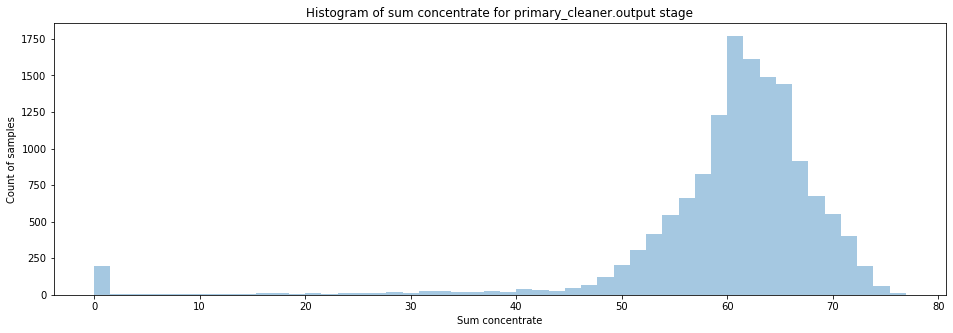

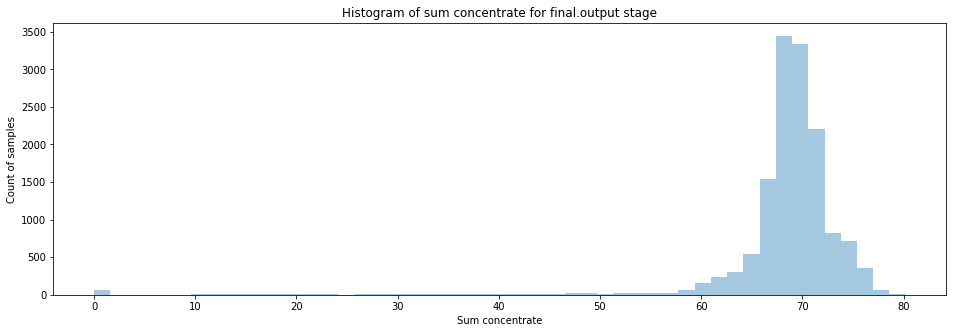

In [32]:
sum_concentrate_train_prepared = get_sum_concentrate(gold_recovery_train_prepared)
print_hist_concentrate_for_every_stage(sum_concentrate_train_prepared)

Как видно из графиков, большое количество аномальных значений исчезло. Для исходного сырья совсем не наблюдается данная ситуация. В дальнейшем, такое может произойти, что на каждом последующем этапе концентрация полезных становится 0, все металлы остались в отвальных хвостах. Модели такое ожидать тоже стоит.

Также здесь стоит обратить внимаение и на эффективности обогащения чернового и финального концентратов. Данные значения рассчитываются исходя из концентратов. Если значения эфективности равно 0, то это означает, что был какой-то сбой.

In [33]:
train_drop_indexes = []

train_drop_indexes.extend(
        list(
            gold_recovery_train_prepared.loc[gold_recovery_train_prepared['rougher.output.recovery'] == 0].index
        )
)
train_drop_indexes.extend(
        list(
            gold_recovery_train_prepared.loc[gold_recovery_train_prepared['final.output.recovery'] == 0].index
        )
)

train_drop_indexes = set(train_drop_indexes)

gold_recovery_train_prepared = gold_recovery_train_prepared.drop(train_drop_indexes)
gold_recovery_train_prepared = gold_recovery_train_prepared.reset_index(drop=True)

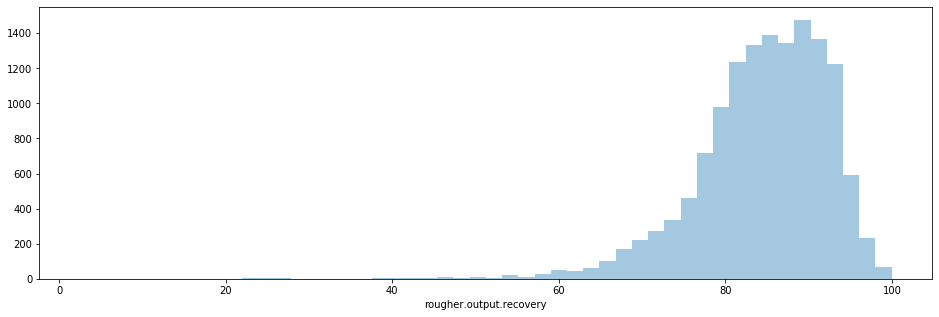

In [34]:
fig, ax = plt.subplots(figsize=(16,5))
sns.distplot(gold_recovery_train_prepared['rougher.output.recovery'], kde=False)
plt.show()

Подготовим тестовую выборку по этому же правилу - удалим строки, где первоначальная суммарная концентрация веществ в исходном сырье равна 0.

In [35]:
cur_stage = stages[0]

In [36]:
sum_concentrate_test = pd.DataFrame()
    
sum_concentrate_test[cur_stage] = pd.Series(0, index=gold_recovery_test.index)
for cur_material in materials:
    sum_concentrate_test[cur_stage] += gold_recovery_test[cur_stage + cur_material]

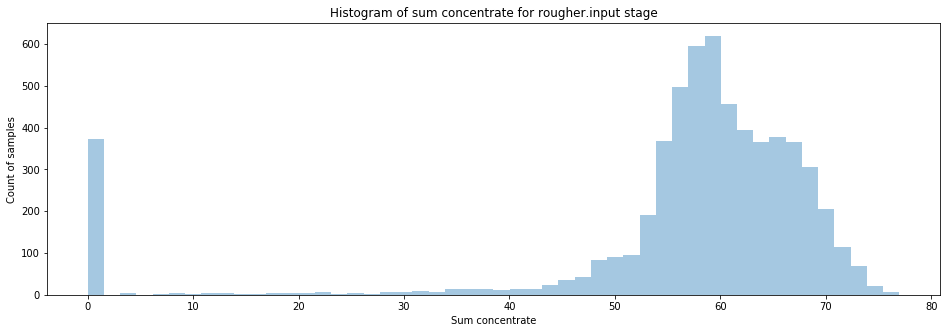

In [37]:
fig, ax = plt.subplots(figsize=(16,5))
sns.distplot(sum_concentrate_test[cur_stage], kde=False, label=cur_stage[:cur_stage.rfind('.')])
plt.title('Histogram of sum concentrate for ' + cur_stage[:cur_stage.rfind('.')] + ' stage')
plt.xlabel('Sum concentrate')
plt.ylabel('Count of samples')
plt.show()

In [38]:
test_drop_indexes = []
test_drop_indexes.extend(list(sum_concentrate_test.loc[sum_concentrate_test[cur_stage] < 1].index))
test_drop_indexes = set(test_drop_indexes)

gold_recovery_test_prepared = gold_recovery_test.drop(test_drop_indexes)
gold_recovery_test_prepared = gold_recovery_test_prepared.reset_index(drop=True)

In [39]:
sum_concentrate_test_prepared = pd.DataFrame()
    
sum_concentrate_test_prepared[cur_stage] = pd.Series(0, index=gold_recovery_test_prepared.index)
for cur_material in materials:
    sum_concentrate_test_prepared[cur_stage] += gold_recovery_test_prepared[cur_stage + cur_material]

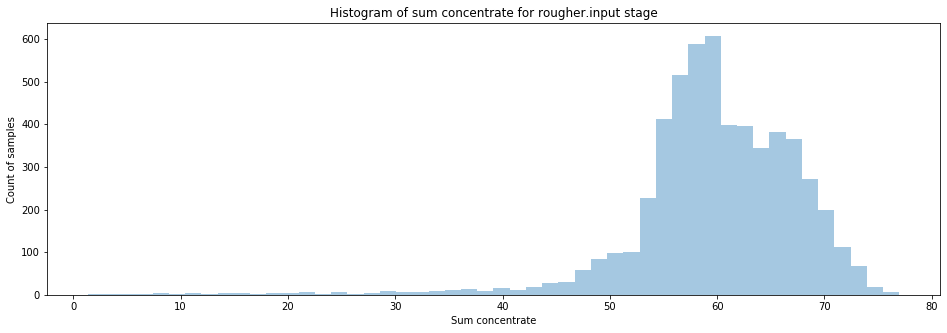

In [40]:
fig, ax = plt.subplots(figsize=(16,5))
sns.distplot(sum_concentrate_test_prepared[cur_stage], kde=False, label=cur_stage[:cur_stage.rfind('.')])
plt.title('Histogram of sum concentrate for ' + cur_stage[:cur_stage.rfind('.')] + ' stage')
plt.xlabel('Sum concentrate')
plt.ylabel('Count of samples')
plt.show()

<a id="step2_4"></a>
### Вывод

На данном этапе мы анализировали данные, чтобы подготовиться к обучению модели. Сначала мы смотрели,как меняется концентрация металлов на каждом этапе. Самый главное, мы убедились что концентрация золота в ходе технологического процесса увеличивается. Также мы сделали выводи и по другим металлам. Затем мы посмотрели на распределение размеров гранул для обучающей и тестовой выборок. Здесь мы убедились, что распределения отличаются не сильно, и на оценку модели данный признак не будет влиять негативно. После, мы определили аномальные значения для суммарных концентраций на каждом этапе. Было решено для обеих выборок удалить наблюдения, где концентрация полезных веществ в исходном сырье равна 0. Данный показатель можно контролировать на входе модели. Если оставить данные строки, то модель будет учитывать и их, что негативно повлияет на определение действительно значимых значений концентраций.

<a id="step3_0"></a>
## 3. Построение и обучение модели

#### [Оглавление](#toc)

<a id="step3_1"></a>
### 3.1 Разработка функции для вычисления итоговой sMAPE

На данном шаге напишем функцию для вычисления метрики качества итоговой sMAPE (симметричное среднее абсолютное процентное отклонение).

Для вычисления итогового sMAPE необходимо предварительно рассчитать отдельные значения sMAPE для эффективности обогащения чернового концентрата и эффективности обогащения финального концентрата. Также напишем функцию для расчета этого значения.

Для расчета sMAPE необхомы целевой признай и предсказания.

In [41]:
def calc_smape_error(target, pred):
    target = target.to_numpy()
    smape = 0
    cur_summa = 0
    
    for i in range(len(target)):
        cur_summa += (abs(target[i] - pred[i])) / ((abs(target[i]) + abs(pred[i])) / 2)
    smape = cur_summa / len(target)
    smape *= 100
    
    return smape

In [42]:
def calc_total_smape_error(rougher_smape, final_smape):   
    final_smape = 0.25 * rougher_smape + 0.75 * final_smape
    return final_smape

<a id="step3_2"></a>
### 3.2 Обучение моделей

На данном этапе мы будем обучать модели и оценивать их качество кросс-валидацией.

Изначально, необходимо выделить признаки на которых будут обучаться модели. Это все признаки из тестовой выборки.

In [43]:
features = gold_recovery_test.columns.values

Далее мы будем обучать модель для предсказывания эффективности обогащения чернового концйентрата. Для этого оставим только признаки, которые характеризуют этап флотации.

In [44]:
features_rougher = []
for cur_feature in features:
    if cur_feature[:cur_feature.find('.')] == 'rougher':
        features_rougher.append(cur_feature)

display(features_rougher)

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level']

Выделим отдельно целевой признак.

In [45]:
features_rougher_train = gold_recovery_train_prepared[features_rougher]
target_rougher_train = gold_recovery_train_prepared['rougher.output.recovery']

Подготовим функции оценки качества для кросс-валидации и поиска по сетке.

In [46]:
custom_score_metric_for_cv = make_scorer(calc_smape_error)
custom_score_metric_for_grid = make_scorer(calc_smape_error, greater_is_better=False)

Рассмотрим несколько моделей, и найдем для каждой оптимальные параметры, для которых значение sMAPE минимальное.

Сначала рассмотрим дерево решений и найдем лучшую глубину.

In [47]:
check_dtr_params = {'max_depth': range (2, 10, 1)}

In [48]:
def find_best_dtr(features, target):
    model = DecisionTreeRegressor(random_state=RAND_SEED)

    grid = GridSearchCV(estimator=model, param_grid=check_dtr_params, cv=5, scoring=custom_score_metric_for_grid)
    grid.fit(features, target)

    best_dtr_depth = grid.best_params_['max_depth']
    return best_dtr_depth

In [49]:
best_dtr_rougher_depth = find_best_dtr(features_rougher_train, target_rougher_train)
print('best_dtr_rougher_depth =', best_dtr_rougher_depth)

best_dtr_rougher_depth = 5


С помощью кросс-валидации оценим значение sMAPE.

In [50]:
model = DecisionTreeRegressor(random_state=RAND_SEED, max_depth=best_dtr_rougher_depth)
scores = cross_val_score(model, features_rougher_train, target_rougher_train, cv=5, scoring=custom_score_metric_for_cv)
score_rougher_dtr = sum(scores) / len(scores)
print(score_rougher_dtr)

7.048396409852411


Далее рассмотрим случайный лес. Помимо глубины деревьев рассмотрим еще количество оценщиков.

In [51]:
check_rfr_params = {'n_estimators': range (100, 150, 20),
                    'max_depth': range (2, 10, 5)}

In [52]:
def find_best_rfr(features, target):
    model = RandomForestRegressor(random_state=RAND_SEED)

    grid = GridSearchCV(estimator=model, param_grid=check_rfr_params, cv=5, scoring=custom_score_metric_for_grid)
    grid.fit(features, target)

    best_rfr_depth = grid.best_params_['max_depth']
    best_rfr_estimators = grid.best_params_['n_estimators']
    
    return best_rfr_depth, best_rfr_estimators

In [53]:
best_rfr_rougher_depth, best_rfr_rougher_estimators = find_best_rfr(features_rougher_train, target_rougher_train)
print('best_rfr_rougher_depth =', best_rfr_rougher_depth)
print('best_rfr_rougher_estimators =', best_rfr_rougher_estimators)

best_rfr_rougher_depth = 7
best_rfr_rougher_estimators = 140


In [54]:
model = RandomForestRegressor(
        random_state=RAND_SEED, 
        max_depth=best_rfr_rougher_depth, 
        n_estimators=best_rfr_rougher_estimators
)
scores = cross_val_score(model, features_rougher_train, target_rougher_train, cv=5, scoring=custom_score_metric_for_cv)
score_rougher_rfr = sum(scores) / len(scores)
print(score_rougher_rfr)

6.713079404239304


Также рассмотрим линейную регрессию. Рассмотрим какую оценку дадут параметры по умолчанию.

In [55]:
model = LinearRegression()
scores = cross_val_score(model, features_rougher_train, target_rougher_train, cv=5, scoring=custom_score_metric_for_cv)
score_rougher_lr = sum(scores) / len(scores)
print(score_rougher_lr)

6.593379664097142


Теперь подберем параметры моделей для предсказания эффективности обогащения финального концентрата.

In [56]:
features_final_train = gold_recovery_train_prepared[features]
features_final_train = features_final_train.drop('date', axis=1)

target_final_train = gold_recovery_train_prepared['final.output.recovery']

In [57]:
best_dtr_final_depth = find_best_dtr(features_final_train, target_final_train)
print('best_dtr_final_depth =', best_dtr_final_depth)

best_dtr_final_depth = 2


In [58]:
model = DecisionTreeRegressor(random_state=RAND_SEED, max_depth=best_dtr_final_depth)
scores = cross_val_score(model, features_final_train, target_final_train, cv=5, scoring=custom_score_metric_for_cv)
score_final_dtr = sum(scores) / len(scores)
print(score_final_dtr)

9.37529807545437


In [59]:
best_rfr_final_depth, best_rfr_final_estimators = find_best_rfr(features_final_train, target_final_train)
print('best_rfr_final_depth =', best_rfr_final_depth)
print('best_rfr_final_estimators =', best_rfr_final_estimators)

best_rfr_final_depth = 2
best_rfr_final_estimators = 140


In [60]:
model = RandomForestRegressor(
        random_state=RAND_SEED, 
        max_depth=best_rfr_final_depth, 
        n_estimators=best_rfr_final_estimators
)
scores = cross_val_score(model, features_final_train, target_final_train, cv=5, scoring=custom_score_metric_for_cv)
score_final_rfr = sum(scores) / len(scores)
print(score_final_rfr)

9.214644152443721


In [61]:
model = LinearRegression()
scores = cross_val_score(model, features_final_train, target_final_train, cv=5, scoring=custom_score_metric_for_cv)
score_final_lr = sum(scores) / len(scores)
print(score_final_lr)

10.954322997110093


Мы рассмотрели по три модели для предсказания 2-х величин. Итоговое sMAPE это сумма sMAPE этих величин. И оно будет тем меньше, чем меньше каждое из слагаемых. Таким образом, мы выберем модели, которые дали минимальные значение sMAPE. Для эффективности обогащения чернового концентрата минимальное значение получилось 6.593 для линейной регресии (случайный лес - 6.713, дерево решений - 7.048). Для эффективности обогащения финального концентрата минимальное значение 9.215 для случайного леса (дерево решений - 9.375, линейная регрессия - 10.954).

In [62]:
total_train_smape = calc_total_smape_error(score_rougher_lr, score_final_rfr)
print(total_train_smape)

8.559328030357076


Мы нашли модели с оптимальными параметрами для тренировочной выборки, теперь необходимо рассчитать итоговое sMAPE на тестовой выборке. 

Для выполнения этой задачи у нас уже есть признаки для обучения. Необходимо выдедить целевой признак, для оценки предсказаний. Воспользуемся для этого первоначальной полной выборкой.

In [63]:
gold_recovery_test_prepared = gold_recovery_test.set_index('date')
gold_recovery_full_prepared = gold_recovery_full.set_index('date')

In [64]:
gold_recovery_test_prepared['rougher.output.recovery'] = gold_recovery_full_prepared['rougher.output.recovery']
gold_recovery_test_prepared['final.output.recovery'] = gold_recovery_full_prepared['final.output.recovery']

In [65]:
gold_recovery_test_prepared.isnull().sum()

primary_cleaner.input.sulfate                   0
primary_cleaner.input.depressant                0
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                  0
primary_cleaner.state.floatbank8_a_air          0
primary_cleaner.state.floatbank8_a_level        0
primary_cleaner.state.floatbank8_b_air          0
primary_cleaner.state.floatbank8_b_level        0
primary_cleaner.state.floatbank8_c_air          0
primary_cleaner.state.floatbank8_c_level        0
primary_cleaner.state.floatbank8_d_air          0
primary_cleaner.state.floatbank8_d_level        0
rougher.input.feed_ag                           0
rougher.input.feed_pb                           0
rougher.input.feed_rate                         0
rougher.input.feed_size                         0
rougher.input.feed_sol                          0
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate               0
rougher.input.floatbank10_xanthate              0


Как и для тестовой выборки подготовим добавленные данные для работы с моделью.

Удалим пропуски в целевых столбцах. И уже после этого заполним пропуски.

In [66]:
print('nulls in rougher.output.recovery:', gold_recovery_test_prepared['rougher.output.recovery'].isnull().sum())
print('nulls in final.output.recovery:', gold_recovery_test_prepared['final.output.recovery'].isnull().sum())

nulls in rougher.output.recovery: 546
nulls in final.output.recovery: 442


In [67]:
gold_recovery_test_prepared.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
gold_recovery_test_prepared = gold_recovery_test_prepared.reset_index(drop=True)

In [68]:
print('nulls in rougher.output.recovery:', gold_recovery_test_prepared['rougher.output.recovery'].isnull().sum())
print('nulls in final.output.recovery:', gold_recovery_test_prepared['final.output.recovery'].isnull().sum())

nulls in rougher.output.recovery: 0
nulls in final.output.recovery: 0


In [71]:
features_rougher_test = gold_recovery_test_prepared[features_rougher]
target_rougher_test = gold_recovery_test_prepared['rougher.output.recovery']

In [72]:
features_final_test = gold_recovery_test_prepared.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_final_test = gold_recovery_test_prepared['final.output.recovery']

Оценим качество итоговых моделей на тестовой выборке.

In [73]:
model_rougher = LinearRegression()
model_rougher.fit(features_rougher_train, target_rougher_train)

predicted_rougher_test = model_rougher.predict(features_rougher_test)
score_rougher_lr_test = calc_smape_error(target_rougher_test, predicted_rougher_test)
print(score_rougher_lr_test)

8.189569777977125


Добавим проверку итоговых моделей на адекватность.

In [74]:
rougher_mean = target_rougher_train.mean()
check_rougher_predictions = pd.Series(rougher_mean, index=target_rougher_test.index)
check_score_rougher = calc_smape_error(target_rougher_test, check_rougher_predictions)
print("Check score_rougher =", check_score_rougher)

Check score_rougher = 9.070086037365206


In [75]:
model_final = RandomForestRegressor(
        random_state=RAND_SEED, 
        max_depth=best_rfr_final_depth, 
        n_estimators=best_rfr_final_estimators
)
model_final.fit(features_final_train, target_final_train)

predicted_final_test = model_final.predict(features_final_test)
score_final_rfr_test = calc_smape_error(target_final_test, predicted_final_test)
print(score_final_rfr_test)

9.301265553004017


In [76]:
final_mean = target_final_train.mean()
check_final_predictions = pd.Series(final_mean, index=target_final_test.index)
check_score_final = calc_smape_error(target_final_test, check_final_predictions)
print("Check score_final =", check_score_final)

Check score_final = 10.081677243445492


In [77]:
total_test_smape = calc_total_smape_error(score_rougher_lr_test, score_final_rfr_test)
print(total_test_smape)

9.023341609247295


<a id="step3_3"></a>
### Вывод

На данном шаге мы строили и обучали модели. Сначала были написаны функции расчета вычисления sMAPE и итоговой sMAPE, которые в дальнейшем используются для оценки качества моделей. После на тренировочной выборке мы подбирали параметры разных моделей для предсказания двух величин: эффективности обогащения чернового концентрата и эффективности обогащения финального концентрата. Для поиска параметров мы использовали поиск по сетке, а для корректной оценки качества использовали кросс-валидацию. Поскольку необходимо было научиться предсказывать две величины с разными набором параметров, мы нашли две отдельные модели с минимальным значением sMAPE. Полученные минимальные метрики получились: 6.593 для линейной регрессии для эффективности обогащения чернового концентрата и 9.215 для случайного леса для эффективновти обогащения финального концентрата. Итоговое sMAPE на тренировочной выборке равно 8.559. Далее мы проверяли наши модели на тестовой выборке. Для этого мы получили необходимые целевые признаки из первоначальной полной выборки с исходными данными и посчитали итоговое sMAPE. Данная метрика на тестовой выборки достигает 9.023.

Мы оценили качество итоговых моделей, полученных на тренировочной выборке, на тестовый данных. Получили значения: 8.189 для эффективности обогащения чернового концентрата и 9.301 для эффективности обогащения финального концентрата. Далее проверили качество этих моделей. Мы взяли среднее значение целевых признаков на тренировочных данных, и оценили значение sMAPE, как если бы модель всегда предсказывала только одно это значение. В первом случае метрика получилась равной 9.07, во втором - 10.082. Оба этих значения превышают предсказанные на наших моделях отклонения. Это означает, что наши модели проходят проверку на адекватность(значение sMAPE тем лучше, чем оно меньше).

<a id="step4_0"></a>
## 4. Общий вывод

#### [Оглавление](#toc)

В данной работе подготовить прототипы модели машинного обучения для «Цифры». Данные модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Для достижения этой цели мы изначально получили данные с параметрами добычи и очистки.<br>
Первым делом мы полготовили данные для дальнейшего анализа и обучения моделей. Проверили, что полученные значения эффективности обогащения чернового концентрата рассчитаны верно. Для этого самостоятельно посчитали это значение и нашли среднее абсолютное отклонение. Далее проанализировали признаки недоступные в тестовой выборке и которые в дальнейшем будут использоваться для предсказания моделей. Также заполнили пропуски и поменяли типы данных для некоторых столбцов.<br>
Вторым шагом последовал анализ данных. Мы посмотрели как изменяются концентрации металлов на каждой стадии технологического процесса. Исследовали распределение размеров гранул сырья на обучающей и тестовой выборках. Они подчиняются одному закону и, соответсвенно, будут одинаково влиять на обучение модели. Проанализированли суммарные концентрации всех веществ на разных стадиях и избавились от аномальных значений.<br>
Третьим шагом мы постоили и обучили модели с оптимальными гиперпараметрами на тренировочной выбокрке. Качество моделей было проверена на тестовой выборке.